# LSTM + GRU Hybrid Model for Stock Prediction

## Imports and Config

In [1]:
#cell 1: imports + seeds + device
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


## Loading the Data

In [2]:
#cell 2: project paths + load panel + filter AAPL
cwd = Path.cwd().resolve()
project_root = None
for p in [cwd] + list(cwd.parents):
    if (p / "data").exists():
        project_root = p
        break
if project_root is None:
    raise RuntimeError("Project root not found: missing /data folder")

DATA_DIR = project_root / "data"
PROC_DIR = DATA_DIR / "processed"

panel_path = PROC_DIR / "modeling_panel_targets.parquet"
print("project_root:", project_root)
print("panel_path:", panel_path)

df = pd.read_parquet(panel_path)
df["date"] = pd.to_datetime(df["date"])

df = df.sort_values(["ticker", "date"]).reset_index(drop=True)
df = df[df["ticker"] == "AAPL"].copy()
df = df.sort_values("date").reset_index(drop=True)

df.columns = (
    pd.Index(df.columns)
    .str.replace("_logret_laglogret_lag", "_logret_lag", regex=False)
)

cols_to_drop = [c for c in df.columns if c.startswith(("MSFT_", "GOOG_", "AMZN_"))]
df = df.drop(columns=cols_to_drop)

print("AAPL df shape:", df.shape)
display(df.head(3))


project_root: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor
panel_path: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/modeling_panel_targets.parquet
AAPL df shape: (3285, 286)


,date,ticker,Open,High,Low,Close,Adj Close,Volume,adj_close,logret_1d,...,^VIX_logret_lag19,AAPL_logret_lag20,CL=F_logret_lag20,GC=F_logret_lag20,QQQ_logret_lag20,SPY_logret_lag20,UUP_logret_lag20,XLK_logret_lag20,^TNX_logret_lag20,^VIX_logret_lag20
0,2013-01-02,AAPL,19.779285,19.821428,19.343929,19.608213,16.612209,560518000.0,16.612209,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,AAPL,19.567142,19.631071,19.321428,19.360714,16.402523,352965200.0,16.402523,-0.012703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,AAPL,19.177500,19.236786,18.779642,18.821428,15.945646,594333600.0,15.945646,-0.028249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#print all the columns in the dataframe
print("Columns in the dataframe:", df.columns.tolist())

Columns in the dataframe: ['date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'adj_close', 'logret_1d', 'ret_1d', 'target_logret_1d', 'hl_range', 'oc_change', 'ret_mean_5', 'ret_vol_5', 'ret_mean_10', 'ret_vol_10', 'ret_mean_20', 'ret_vol_20', 'ret_mean_60', 'ret_vol_60', 'sma_5', 'sma_10', 'sma_20', 'sma_60', 'sma_spread_5', 'sma_spread_20', 'sma_spread_60', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_hist', 'rsi_14', 'bb_mid_20', 'bb_std_20', 'bb_upper_20', 'bb_lower_20', 'bb_width_20', 'vol_change', 'vol_z_20', 'obv', 'dow', 'month', 'is_month_end', 'logret_1d_lag1', 'logret_1d_lag2', 'logret_1d_lag3', 'logret_1d_lag4', 'logret_1d_lag5', 'logret_1d_lag6', 'logret_1d_lag7', 'logret_1d_lag8', 'logret_1d_lag9', 'logret_1d_lag10', 'logret_1d_lag11', 'logret_1d_lag12', 'logret_1d_lag13', 'logret_1d_lag14', 'logret_1d_lag15', 'logret_1d_lag16', 'logret_1d_lag17', 'logret_1d_lag18', 'logret_1d_lag19', 'logret_1d_lag20', 'logret_1d_lag21', 'logret_1d_lag22', 'logr

## Data Split

In [ ]:
#cell 3: define X/y and time split

TARGET = "target_logret_1d"

drop_cols = {"date", "ticker", TARGET}

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop any other future-looking columns (avoid leakage)
# - keep your old target_* drop logic
# - ALSO drop other next_* columns except the chosen TARGET
leak_cols = [c for c in num_cols if (c.startswith("target_") or c.startswith("next_")) and c != TARGET]
drop_cols = drop_cols.union(leak_cols)

feature_cols = [c for c in num_cols if c not in drop_cols]

print("Dropped potential leakage columns:", len(leak_cols))
if len(leak_cols) > 0:
    print("Examples:", leak_cols[:10])

model_df = df[["date", TARGET] + feature_cols].dropna().reset_index(drop=True)

n = len(model_df)
split_idx = int(n * 0.80)

train_df = model_df.iloc[:split_idx].copy()
test_df  = model_df.iloc[split_idx:].copy()

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET].copy()

X_test  = test_df[feature_cols].copy()
y_test  = test_df[TARGET].copy()

print("model_df shape:", model_df.shape)
print("train rows:", len(train_df), "test rows:", len(test_df))
print("train date range:", train_df["date"].min(), "to", train_df["date"].max())
print("test  date range:", test_df["date"].min(), "to", test_df["date"].max())



Dropped potential leakage columns: 0
model_df shape: (3097, 285)
train rows: 2477 test rows: 620
train date range: 2013-04-02 00:00:00 to 2023-06-01 00:00:00
test  date range: 2023-06-02 00:00:00 to 2026-01-22 00:00:00


In [5]:
print("Any target_* columns still in features?",
      any(c.startswith("target_") for c in feature_cols))

Any target_* columns still in features? False


## Scaling and PCA

In [6]:
#cell 4: StandardScaler + PCA(80% variance)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train.values)
X_test_s  = scaler.transform(X_test.values)

pca = PCA(n_components=0.80, svd_solver="full")
X_train_p = pca.fit_transform(X_train_s)
X_test_p  = pca.transform(X_test_s)

pca_columns = [f"pca_{i+1}" for i in range(pca.n_components_)]

print("PCA components for 80% variance:", pca.n_components_)
print("Explained variance ratio sum:", float(pca.explained_variance_ratio_.sum()))
print("X_train_p:", X_train_p.shape, "X_test_p:", X_test_p.shape)


PCA components for 80% variance: 91
Explained variance ratio sum: 0.8022804105397852
X_train_p: (2477, 91) X_test_p: (620, 91)


## Sliding Window Sequences

In [7]:
#cell 5: build sliding-window sequences (lookback=60) with test continuity
LOOKBACK = 60

def make_sequences(X_2d, y_1d, lookback):
    Xs, ys = [], []
    for t in range(lookback, len(X_2d)):
        Xs.append(X_2d[t - lookback:t])
        ys.append(y_1d[t])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

Xtr_seq, ytr_seq = make_sequences(X_train_p, y_train.values, LOOKBACK)

#test continuity: prepend last LOOKBACK rows of train to test features, then keep test targets only
X_test_full = np.vstack([X_train_p[-LOOKBACK:], X_test_p])
y_test_full = np.concatenate([y_train.values[-LOOKBACK:], y_test.values])

Xte_seq_all, yte_seq_all = make_sequences(X_test_full, y_test_full, LOOKBACK)

#only keep sequences whose target is in the real test period
Xte_seq = Xte_seq_all
yte_seq = yte_seq_all

print("train sequences:", Xtr_seq.shape, ytr_seq.shape)
print("test  sequences:", Xte_seq.shape, yte_seq.shape)


train sequences: (2417, 60, 91) (2417,)
test  sequences: (620, 60, 91) (620,)


## Temporal Train/Val Split

In [8]:
#cell 6: temporal train/val split on sequences (train-only)
n_train_seq = len(Xtr_seq)
val_start = int(n_train_seq * 0.90)

Xtr2, ytr2 = Xtr_seq[:val_start], ytr_seq[:val_start]
Xva,  yva  = Xtr_seq[val_start:], ytr_seq[val_start:]

print("train2:", Xtr2.shape, ytr2.shape)
print("val   :", Xva.shape, yva.shape)


train2: (2175, 60, 91) (2175,)
val   : (242, 60, 91) (242,)


In [9]:
# DIAG: exact target-date ranges for sequences and splits
train_target_dates = train_df["date"].values[LOOKBACK:]   # one per ytr_seq
val_start = int(len(train_target_dates) * 0.90)

print("Train target dates total:", len(train_target_dates), "== ytr_seq:", len(ytr_seq))
print("Train2 targets:", val_start, "| Val targets:", len(train_target_dates) - val_start)

print("TRAIN2 date range:",
      pd.to_datetime(train_target_dates[0]),
      "to",
      pd.to_datetime(train_target_dates[val_start-1]))

print("VAL date range:",
      pd.to_datetime(train_target_dates[val_start]),
      "to",
      pd.to_datetime(train_target_dates[-1]))

print("TEST date range:",
      pd.to_datetime(test_df["date"].values[0]),
      "to",
      pd.to_datetime(test_df["date"].values[-1]))


Train target dates total: 2417 == ytr_seq: 2417
Train2 targets: 2175 | Val targets: 242
TRAIN2 date range: 2013-06-26 00:00:00 to 2022-06-14 00:00:00
VAL date range: 2022-06-15 00:00:00 to 2023-06-01 00:00:00
TEST date range: 2023-06-02 00:00:00 to 2026-01-22 00:00:00


## Loading the LSTM + GRU Model

In [10]:
#cell 7: torch datasets + loaders
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_loader(X, y, batch_size, shuffle):
    ds = SeqDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)

print("ready")


ready


In [11]:
#cell 8: LSTM -> GRU -> Dense -> Dense -> Output model
class LSTMGRU(nn.Module):
    def __init__(self, n_features, hidden_lstm=128, hidden_gru=128, dense1=64, dense2=32, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_lstm, batch_first=True)
        self.gru  = nn.GRU(input_size=hidden_lstm, hidden_size=hidden_gru, batch_first=True)
        self.fc1  = nn.Linear(hidden_gru, dense1)
        self.fc2  = nn.Linear(dense1, dense2)
        self.out  = nn.Linear(dense2, 1)
        self.act  = nn.ReLU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.act(self.fc2(x)))
        y = self.out(x).squeeze(-1)
        return y

print("ready")


ready


In [12]:
#cell 9: training utilities

from sklearn.metrics import r2_score

def rmse_np(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def r2_np(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(r2_score(y_true, y_pred))


@torch.no_grad()
def predict_loader(model, loader):
    model.eval()
    preds = []
    ys = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        p = model(xb)
        preds.append(p.detach().cpu().numpy())
        ys.append(yb.detach().cpu().numpy())
    return np.concatenate(ys), np.concatenate(preds)

def train_one_trial(model, train_loader, val_loader, lr, weight_decay, grad_clip, max_epochs, patience):
    crit = nn.MSELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_rmse = float("inf")
    best_state = None
    no_improve = 0

    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            opt.step()

        yv_true, yv_pred = predict_loader(model, val_loader)
        val_rmse = rmse_np(yv_true, yv_pred)

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    model.load_state_dict(best_state)
    return float(best_val_rmse)




## Training the Model

In [ ]:
#cell 10: Grid Search (single validation split + resume + append-to-CSV per run)

#####OLD CELL#######

import itertools
import time
import json

N_FEATURES = Xtr2.shape[-1]

# ---- Grid (edit ONLY these lists to widen/narrow the grid) ----
GRID = {
    "hidden_lstm":  [64, 128, 256],
    "hidden_gru":   [64, 128, 256],
    "dense1":       [32, 64, 128],
    "dense2":       [16, 32, 64],
    "dropout":      [0.0, 0.2],
    "lr":           [5e-4, 1e-3],
    "weight_decay": [1e-6, 1e-4],
    "batch_size":   [64, 128],
    "grad_clip":    [1.0],
}

MAX_EPOCHS = 50
PATIENCE = 7
BASE_SEED = 42

runs_path = PROC_DIR / "phase2_gridsearch_runs_next_day_rmse.csv"

param_keys = list(GRID.keys())
all_params = [
    dict(zip(param_keys, vals))
    for vals in itertools.product(*[GRID[k] for k in param_keys])
]
print("total grid combinations:", len(all_params))
print("runs_path:", runs_path)

def config_to_id(p):
    # stable + comparable across sessions for resume/skip
    return json.dumps(p, sort_keys=True)

def append_row_csv(path, row, columns):
    dfrow = pd.DataFrame([row], columns=columns)
    header = not path.exists()
    dfrow.to_csv(path, mode="a", header=header, index=False)

# Resume support: skip already completed configs (by config_id)
done_ids = set()
next_run_id = 1
if runs_path.exists():
    prev = pd.read_csv(runs_path)
    if len(prev) > 0:
        if "config_id" in prev.columns:
            done_ids = set(prev["config_id"].astype(str).tolist())
        next_run_id = int(prev["run_id"].max()) + 1

columns = [
    "run_id", "seed", "status",
    "val_rmse", "val_r2",
    "train_seconds", "config_id", "error_msg",
    *param_keys
]

best_val = float("inf")

best_params = None
best_run_id = None

print("starting grid search...")
for p in all_params:
    cfg_id = config_to_id(p)
    if cfg_id in done_ids:
        continue

    run_id = next_run_id
    next_run_id += 1

    # per-run seeding -> reproducible per configuration
    seed = BASE_SEED + run_id
    set_seed(seed)

    train_loader = make_loader(Xtr2, ytr2, batch_size=int(p["batch_size"]), shuffle=True)
    val_loader   = make_loader(Xva,  yva,  batch_size=int(p["batch_size"]), shuffle=False)

    model = LSTMGRU(
        n_features=N_FEATURES,
        hidden_lstm=int(p["hidden_lstm"]),
        hidden_gru=int(p["hidden_gru"]),
        dense1=int(p["dense1"]),
        dense2=int(p["dense2"]),
        dropout=float(p["dropout"]),
    ).to(device)

    t0 = time.time()
    status = "ok"
    err_msg = ""

    try:
        val_rmse = train_one_trial(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=float(p["lr"]),
            weight_decay=float(p["weight_decay"]),
            grad_clip=float(p["grad_clip"]),
            max_epochs=MAX_EPOCHS,
            patience=PATIENCE
        )

        # model is now at best-val-RMSE state; compute val_r2 for logging
        yv_true, yv_pred = predict_loader(model, val_loader)
        val_r2 = r2_np(yv_true, yv_pred)


    except Exception as e:
        val_rmse = np.nan
        val_r2 = np.nan
        status = f"error:{type(e).__name__}"
        err_msg = str(e)[:1500]

    train_seconds = float(time.time() - t0)

    row = {
        "run_id": run_id,
        "seed": seed,
        "status": status,
        "val_rmse": float(val_rmse) if np.isfinite(val_rmse) else np.nan,
        "val_r2": float(val_r2) if np.isfinite(val_r2) else np.nan,
        "train_seconds": train_seconds,
        "config_id": cfg_id,
        "error_msg": err_msg,
        **p
    }

    # SAVE IMMEDIATELY after each run
    append_row_csv(runs_path, row, columns)

    print(f"[run {run_id}] status={status} val_rmse={row['val_rmse']:.6f} val_r2={row['val_r2']:.6f} params={p}")

    if status == "ok" and np.isfinite(val_rmse) and val_rmse < best_val:
        best_val = float(val_rmse)
        best_params = dict(p)
        best_run_id = run_id

    # cleanup between runs (helps GPU memory)
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Report best-so-far (also works if you stopped and resumed later)
if runs_path.exists():
    runs = pd.read_csv(runs_path)
    runs_ok = runs[runs["status"].astype(str) == "ok"].copy()
    runs_ok = runs_ok.dropna(subset=["val_rmse"])
    runs_ok = runs_ok.sort_values("val_rmse", ascending=True)


    if len(runs_ok) > 0:
        top = runs_ok.iloc[0]
        best_run_id = int(top["run_id"])
        best_val = float(top["val_rmse"])
        best_params = {k: top[k] for k in param_keys}

        # cast types cleanly
        for k in ["hidden_lstm","hidden_gru","dense1","dense2","batch_size"]:
            best_params[k] = int(best_params[k])
        for k in ["dropout","lr","weight_decay","grad_clip"]:
            best_params[k] = float(best_params[k])

        print("\nBEST (from CSV):")
        print("best_run_id:", best_run_id)
        print("best val_rmse:", best_val)
        print("best val_r2:", float(top["val_r2"]))

        print("best params:", best_params)
    else:
        print("\nNo successful runs yet (check errors in the CSV).")


total grid combinations: 1296
runs_path: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase2_gridsearch_runs_next_day_rmse.csv
starting grid search...
[run 1] status=ok val_rmse=0.019495 val_r2=-0.027683 params={'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 16, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay': 1e-06, 'batch_size': 64, 'grad_clip': 1.0}
[run 2] status=ok val_rmse=0.020121 val_r2=-0.094786 params={'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 16, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay': 1e-06, 'batch_size': 128, 'grad_clip': 1.0}
[run 3] status=ok val_rmse=0.019504 val_r2=-0.028648 params={'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 16, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 64, 'grad_clip': 1.0}
[run 4] status=ok val_rmse=0.020750 val_r2=-0.164273 params={'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 16, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay':

In [13]:
#cell 10: Grid Search (single validation split + resume + append-to-CSV per run)
import itertools
import time
import json

N_FEATURES = Xtr2.shape[-1]

# ---- Grid (edit ONLY these lists to widen/narrow the grid) ----
GRID = {
    "hidden_lstm":  [64, 128, 256],
    "hidden_gru":   [64, 128, 256],
    "dense1":       [32, 64, 128],
    "dense2":       [16, 32, 64],
    "dropout":      [0.0, 0.2],
    "lr":           [5e-4, 1e-3],
    "weight_decay": [1e-6, 1e-4],
    "batch_size":   [64, 128],
    "grad_clip":    [1.0],
}

MAX_EPOCHS = 50
PATIENCE = 7
BASE_SEED = 42

runs_path = PROC_DIR / "phase2_gridsearch_runs_next_day_rmse_FIXED.csv"

param_keys = list(GRID.keys())
all_params = [
    dict(zip(param_keys, vals))
    for vals in itertools.product(*[GRID[k] for k in param_keys])
]

print("total grid combinations:", len(all_params))
print("runs_path:", runs_path)

def config_to_id(p):
    # stable + comparable across sessions for resume/skip
    return json.dumps(p, sort_keys=True)

def append_row_csv(path, row, columns):
    dfrow = pd.DataFrame([row], columns=columns)
    header = not path.exists()
    dfrow.to_csv(path, mode="a", header=header, index=False)

# Resume support: skip already completed configs (by config_id)
done_ids = set()
next_run_id = 1
if runs_path.exists():
    prev = pd.read_csv(runs_path)
    if len(prev) > 0:
        if "config_id" in prev.columns:
            done_ids = set(prev["config_id"].astype(str).tolist())
        next_run_id = int(prev["run_id"].max()) + 1

columns = [
    "run_id", "seed", "status",
    "val_rmse", "val_r2",
    "train_seconds", "config_id", "error_msg",
    *param_keys
]

best_val = float("inf")
best_params = None
best_run_id = None

print("starting grid search...")

for p in all_params:
    cfg_id = config_to_id(p)
    if cfg_id in done_ids:
        continue
    
    run_id = next_run_id
    next_run_id += 1
    
    #same seed for ALL configs (fair comparison)
    seed = BASE_SEED  
    set_seed(seed)
    
    train_loader = make_loader(Xtr2, ytr2, batch_size=int(p["batch_size"]), shuffle=True)
    val_loader   = make_loader(Xva,  yva,  batch_size=int(p["batch_size"]), shuffle=False)
    
    model = LSTMGRU(
        n_features=N_FEATURES,
        hidden_lstm=int(p["hidden_lstm"]),
        hidden_gru=int(p["hidden_gru"]),
        dense1=int(p["dense1"]),
        dense2=int(p["dense2"]),
        dropout=float(p["dropout"]),
    ).to(device)
    
    t0 = time.time()
    status = "ok"
    err_msg = ""
    
    try:
        val_rmse = train_one_trial(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=float(p["lr"]),
            weight_decay=float(p["weight_decay"]),
            grad_clip=float(p["grad_clip"]),
            max_epochs=MAX_EPOCHS,
            patience=PATIENCE
        )
        # model is now at best-val-RMSE state; compute val_r2 for logging
        yv_true, yv_pred = predict_loader(model, val_loader)
        val_r2 = r2_np(yv_true, yv_pred)
    except Exception as e:
        val_rmse = np.nan
        val_r2 = np.nan
        status = f"error:{type(e).__name__}"
        err_msg = str(e)[:1500]
    
    train_seconds = float(time.time() - t0)
    
    row = {
        "run_id": run_id,
        "seed": seed,
        "status": status,
        "val_rmse": float(val_rmse) if np.isfinite(val_rmse) else np.nan,
        "val_r2": float(val_r2) if np.isfinite(val_r2) else np.nan,
        "train_seconds": train_seconds,
        "config_id": cfg_id,
        "error_msg": err_msg,
        **p
    }
    
    # SAVE IMMEDIATELY after each run
    append_row_csv(runs_path, row, columns)
    
    print(f"[run {run_id}] status={status} val_rmse={row['val_rmse']:.6f} val_r2={row['val_r2']:.6f} params={p}")
    
    if status == "ok" and np.isfinite(val_rmse) and val_rmse < best_val:
        best_val = float(val_rmse)
        best_params = dict(p)
        best_run_id = run_id
    
    # cleanup between runs (helps GPU memory)
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Report best-so-far (also works if you stopped and resumed later)
if runs_path.exists():
    runs = pd.read_csv(runs_path)
    runs_ok = runs[runs["status"].astype(str) == "ok"].copy()
    runs_ok = runs_ok.dropna(subset=["val_rmse"])
    runs_ok = runs_ok.sort_values("val_rmse", ascending=True)
    
    if len(runs_ok) > 0:
        top = runs_ok.iloc[0]
        best_run_id = int(top["run_id"])
        best_val = float(top["val_rmse"])
        best_params = {k: top[k] for k in param_keys}
        # cast types cleanly
        for k in ["hidden_lstm","hidden_gru","dense1","dense2","batch_size"]:
            best_params[k] = int(best_params[k])
        for k in ["dropout","lr","weight_decay","grad_clip"]:
            best_params[k] = float(best_params[k])
        
        print("\nBEST (from CSV):")
        print("best_run_id:", best_run_id)
        print("best val_rmse:", best_val)
        print("best val_r2:", float(top["val_r2"]))
        print("best params:", best_params)
    else:
        print("\nNo successful runs yet (check errors in the CSV).")

total grid combinations: 1296
runs_path: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase2_gridsearch_runs_next_day_rmse_FIXED.csv
starting grid search...
[run 1] status=ok val_rmse=0.019171 val_r2=0.006173 params={'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 16, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay': 1e-06, 'batch_size': 64, 'grad_clip': 1.0}
[run 2] status=ok val_rmse=0.019042 val_r2=0.019480 params={'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 16, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay': 1e-06, 'batch_size': 128, 'grad_clip': 1.0}
[run 3] status=ok val_rmse=0.019171 val_r2=0.006175 params={'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 16, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 64, 'grad_clip': 1.0}
[run 4] status=ok val_rmse=0.019042 val_r2=0.019480 params={'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 16, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay

In [14]:
#cell 11: retrain TOP 10 configs from CSV and print results (no saving)
grid_path = PROC_DIR / "phase2_gridsearch_runs_next_day_rmse_FIXED.csv"
runs = pd.read_csv(grid_path)

runs_ok = runs[runs["status"].astype(str) == "ok"].copy()
runs_ok = runs_ok.dropna(subset=["val_rmse"]).sort_values("val_rmse", ascending=True)

TOPK = 10
top_runs = runs_ok.head(TOPK).reset_index(drop=True)

if len(top_runs) == 0:
    raise RuntimeError("No successful grid runs found. Check phase2_gridsearch_runs_rmse.csv error_msg column.")

print("Top runs loaded:", len(top_runs))
display(top_runs[["run_id","seed","val_rmse","val_r2","hidden_lstm","hidden_gru","dense1","dense2","dropout","lr","weight_decay","batch_size","grad_clip"]])

# Use SAME split as grid search (this matches your Cell 6 logic)
batch_size_default = int(top_runs.loc[0, "batch_size"])

n_train_seq = len(Xtr_seq)
val_start = int(n_train_seq * 0.90)
XtrF, ytrF = Xtr_seq[:val_start], ytr_seq[:val_start]
XvaF, yvaF = Xtr_seq[val_start:], ytr_seq[val_start:]

# We'll recreate loaders per run because batch_size changes
MAX_EPOCHS = 50
PATIENCE = 7

results = []
best_val_rmse = float("inf")
best_state = None
best_run_id = None
best_params = None
best_val_r2 = None

for i in range(len(top_runs)):
    r = top_runs.iloc[i]

    params = {
        "hidden_lstm":  int(r["hidden_lstm"]),
        "hidden_gru":   int(r["hidden_gru"]),
        "dense1":       int(r["dense1"]),
        "dense2":       int(r["dense2"]),
        "dropout":      float(r["dropout"]),
        "lr":           float(r["lr"]),
        "weight_decay": float(r["weight_decay"]),
        "batch_size":   int(r["batch_size"]),
        "grad_clip":    float(r["grad_clip"]),
    }

    run_id = int(r["run_id"])
    seed = int(r["seed"])
    csv_val_rmse = float(r["val_rmse"])
    csv_val_r2 = float(r["val_r2"])

    set_seed(seed)

    train_loaderF = make_loader(XtrF, ytrF, batch_size=params["batch_size"], shuffle=True)
    val_loaderF   = make_loader(XvaF, yvaF, batch_size=params["batch_size"], shuffle=False)

    model = LSTMGRU(
        n_features=Xtr_seq.shape[-1],
        hidden_lstm=params["hidden_lstm"],
        hidden_gru=params["hidden_gru"],
        dense1=params["dense1"],
        dense2=params["dense2"],
        dropout=params["dropout"],
    ).to(device)

    best_rmse_train = train_one_trial(
        model=model,
        train_loader=train_loaderF,
        val_loader=val_loaderF,
        lr=params["lr"],
        weight_decay=params["weight_decay"],
        grad_clip=params["grad_clip"],
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE
    )

    # compute RMSE + R2 on val at the loaded-best state
    yva_true, yva_pred = predict_loader(model, val_loaderF)
    val_rmse_retrain = rmse_np(yva_true, yva_pred)
    val_r2_retrain = r2_np(yva_true, yva_pred)


    out = {
        "rank": i+1,
        "run_id": run_id,
        "seed": seed,
        "csv_val_rmse": csv_val_rmse,
        "csv_val_r2": csv_val_r2,
        "retrain_val_rmse": float(val_rmse_retrain),
        "retrain_val_r2": float(val_r2_retrain),
        **params
    }
    results.append(out)

    print(f"\n[{i+1}/{TOPK}] run_id={run_id} seed={seed}")
    print("params:", params)
    print(f"csv val_rmse={csv_val_rmse:.6f} csv val_r2={csv_val_r2:.6f} | retrain val_rmse={val_rmse_retrain:.6f} retrain val_r2={val_r2_retrain:.6f}")

    # keep best retrained model (by lowest RMSE)
    if val_rmse_retrain < best_val_rmse:
        best_val_rmse = float(val_rmse_retrain)
        best_val_r2 = float(val_r2_retrain)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_run_id = run_id
        best_params = dict(params)

    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

results_df = pd.DataFrame(results).sort_values("retrain_val_rmse", ascending=True)
print("\nSUMMARY (sorted by retrain_val_rmse):")
display(results_df)

print("\nCHOSEN BEST (by retrain_val_rmse): run_id =", best_run_id,
      "val_rmse =", best_val_rmse, "val_r2 =", best_val_r2)
best = best_params

final_model = LSTMGRU(
    n_features=Xtr_seq.shape[-1],
    hidden_lstm=best["hidden_lstm"],
    hidden_gru=best["hidden_gru"],
    dense1=best["dense1"],
    dense2=best["dense2"],
    dropout=best["dropout"],
).to(device)

final_model.load_state_dict(best_state)


Top runs loaded: 10


,run_id,seed,val_rmse,val_r2,hidden_lstm,hidden_gru,dense1,dense2,dropout,lr,weight_decay,batch_size,grad_clip
0,170,42,0.018871,0.036976,64,128,32,32,0.2,0.0005,0.000001,128,1.0
1,172,42,0.018871,0.036975,64,128,32,32,0.2,0.0005,0.000100,128,1.0
2,575,42,0.018930,0.030953,128,64,128,64,0.2,0.0010,0.000100,64,1.0
3,573,42,0.018930,0.030948,128,64,128,64,0.2,0.0010,0.000001,64,1.0
4,166,42,0.018958,0.028153,64,128,32,32,0.0,0.0010,0.000001,128,1.0
5,168,42,0.018958,0.028152,64,128,32,32,0.0,0.0010,0.000100,128,1.0
6,163,42,0.018979,0.025961,64,128,32,32,0.0,0.0005,0.000100,64,1.0
7,161,42,0.018979,0.025961,64,128,32,32,0.0,0.0005,0.000001,64,1.0
8,176,42,0.018994,0.024421,64,128,32,32,0.2,0.0010,0.000100,128,1.0
9,174,42,0.018994,0.024420,64,128,32,32,0.2,0.0010,0.000001,128,1.0



[1/10] run_id=170 seed=42
params: {'hidden_lstm': 64, 'hidden_gru': 128, 'dense1': 32, 'dense2': 32, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 1e-06, 'batch_size': 128, 'grad_clip': 1.0}
csv val_rmse=0.018871 csv val_r2=0.036976 | retrain val_rmse=0.018871 retrain val_r2=0.036976

[2/10] run_id=172 seed=42
params: {'hidden_lstm': 64, 'hidden_gru': 128, 'dense1': 32, 'dense2': 32, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 128, 'grad_clip': 1.0}
csv val_rmse=0.018871 csv val_r2=0.036975 | retrain val_rmse=0.018871 retrain val_r2=0.036975

[3/10] run_id=575 seed=42
params: {'hidden_lstm': 128, 'hidden_gru': 64, 'dense1': 128, 'dense2': 64, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 64, 'grad_clip': 1.0}
csv val_rmse=0.018930 csv val_r2=0.030953 | retrain val_rmse=0.018930 retrain val_r2=0.030953

[4/10] run_id=573 seed=42
params: {'hidden_lstm': 128, 'hidden_gru': 64, 'dense1': 128, 'dense2': 64, 'dropout': 0.2, 'lr': 0.001, 'weight_d

,rank,run_id,seed,csv_val_rmse,csv_val_r2,retrain_val_rmse,retrain_val_r2,hidden_lstm,hidden_gru,dense1,dense2,dropout,lr,weight_decay,batch_size,grad_clip
0,1,170,42,0.018871,0.036976,0.018871,0.036976,64,128,32,32,0.2,0.0005,0.000001,128,1.0
1,2,172,42,0.018871,0.036975,0.018871,0.036975,64,128,32,32,0.2,0.0005,0.000100,128,1.0
2,3,575,42,0.018930,0.030953,0.018930,0.030953,128,64,128,64,0.2,0.0010,0.000100,64,1.0
3,4,573,42,0.018930,0.030948,0.018930,0.030948,128,64,128,64,0.2,0.0010,0.000001,64,1.0
4,5,166,42,0.018958,0.028153,0.018958,0.028153,64,128,32,32,0.0,0.0010,0.000001,128,1.0
5,6,168,42,0.018958,0.028152,0.018958,0.028152,64,128,32,32,0.0,0.0010,0.000100,128,1.0
6,7,163,42,0.018979,0.025961,0.018979,0.025961,64,128,32,32,0.0,0.0005,0.000100,64,1.0
7,8,161,42,0.018979,0.025961,0.018979,0.025961,64,128,32,32,0.0,0.0005,0.000001,64,1.0
8,9,176,42,0.018994,0.024421,0.018994,0.024421,64,128,32,32,0.2,0.0010,0.000100,128,1.0
9,10,174,42,0.018994,0.024420,0.018994,0.024420,64,128,32,32,0.2,0.0010,0.000001,128,1.0



CHOSEN BEST (by retrain_val_rmse): run_id = 170 val_rmse = 0.018871407955884933 val_r2 = 0.036976158618927


<All keys matched successfully>

In [17]:
print("Evaluating best_run_id:", best_run_id)
print("Evaluating best params:", best)

Evaluating best_run_id: 397
Evaluating best params: {'hidden_lstm': 64, 'hidden_gru': 256, 'dense1': 128, 'dense2': 16, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 1e-06, 'batch_size': 64, 'grad_clip': 1.0}


In [24]:
# DIAG: seed sensitivity for one chosen parameter set (e.g., run48)
params = {
    "hidden_lstm": 64,
    "hidden_gru": 256,
    "dense1": 128,
    "dense2": 16,
    "dropout": 0.2,
    "lr": 1e-3,
    "weight_decay": 1e-6,
    "batch_size": 64,
    "grad_clip": 1.0,
}

SEEDS = [42, 43, 44, 45, 46]

rows = []
for s in SEEDS:
    set_seed(s)

    train_loader = make_loader(Xtr2, ytr2, batch_size=params["batch_size"], shuffle=True)
    val_loader   = make_loader(Xva,  yva,  batch_size=params["batch_size"], shuffle=False)

    model = LSTMGRU(
        n_features=Xtr2.shape[-1],
        hidden_lstm=params["hidden_lstm"],
        hidden_gru=params["hidden_gru"],
        dense1=params["dense1"],
        dense2=params["dense2"],
        dropout=params["dropout"],
    ).to(device)

    _ = train_one_trial(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=params["lr"],
        weight_decay=params["weight_decay"],
        grad_clip=params["grad_clip"],
        max_epochs=50,
        patience=7
    )

    yv_true, yv_pred = predict_loader(model, val_loader)
    yt_true, yt_pred = predict_loader(model, make_loader(Xte_seq, yte_seq, batch_size=256, shuffle=False))

    rows.append({
        "seed": s,
        "val_rmse": rmse_np(yv_true, yv_pred),
        "val_r2": r2_np(yv_true, yv_pred),
        "test_rmse": rmse_np(yt_true, yt_pred),
        "test_r2": r2_np(yt_true, yt_pred),
    })

    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

diag_df = pd.DataFrame(rows)
display(diag_df)
print("VAL_RMSE mean/std:", diag_df["val_rmse"].mean(), diag_df["val_rmse"].std())
print("TEST_RMSE mean/std:", diag_df["test_rmse"].mean(), diag_df["test_rmse"].std())


,seed,val_rmse,val_r2,test_rmse,test_r2
0,42,0.020424,-0.127952,0.018314,-0.257805
1,43,0.019620,-0.040975,0.016607,-0.034273
2,44,0.019481,-0.026276,0.016626,-0.036652
3,45,0.020275,-0.111624,0.017795,-0.187600
4,46,0.021000,-0.192471,0.017392,-0.134355


VAL_RMSE mean/std: 0.020159976929426192 0.0006203700462214437
TEST_RMSE mean/std: 0.017346567288041116 0.0007424950900551723


In [16]:
# POST-CHECK: evaluate TOPK configs across multiple seeds (no full rerun)

SEEDS = [42, 43, 44, 45, 46]   # reduce to [42,43,44] if you need faster
TOPK_CHECK = min(10, len(top_runs))

rows = []

for i in range(TOPK_CHECK):
    r = top_runs.iloc[i]

    params = {
        "hidden_lstm":  int(r["hidden_lstm"]),
        "hidden_gru":   int(r["hidden_gru"]),
        "dense1":       int(r["dense1"]),
        "dense2":       int(r["dense2"]),
        "dropout":      float(r["dropout"]),
        "lr":           float(r["lr"]),
        "weight_decay": float(r["weight_decay"]),
        "batch_size":   int(r["batch_size"]),
        "grad_clip":    float(r["grad_clip"]),
    }

    for seed in SEEDS:
        set_seed(seed)

        train_loader = make_loader(XtrF, ytrF, batch_size=params["batch_size"], shuffle=True)
        val_loader   = make_loader(XvaF, yvaF, batch_size=params["batch_size"], shuffle=False)
        test_loader  = make_loader(Xte_seq, yte_seq, batch_size=256, shuffle=False)

        model = LSTMGRU(
            n_features=Xtr_seq.shape[-1],
            hidden_lstm=params["hidden_lstm"],
            hidden_gru=params["hidden_gru"],
            dense1=params["dense1"],
            dense2=params["dense2"],
            dropout=params["dropout"],
        ).to(device)

        _ = train_one_trial(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=params["lr"],
            weight_decay=params["weight_decay"],
            grad_clip=params["grad_clip"],
            max_epochs=50,
            patience=7
        )

        yv_true, yv_pred = predict_loader(model, val_loader)
        yt_true, yt_pred = predict_loader(model, test_loader)

        rows.append({
            "orig_rank": i+1,
            "run_id": int(r["run_id"]),
            "seed": seed,
            "val_rmse": rmse_np(yv_true, yv_pred),
            "val_r2": r2_np(yv_true, yv_pred),
            "test_rmse": rmse_np(yt_true, yt_pred),
            "test_r2": r2_np(yt_true, yt_pred),
            **params
        })

        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

multi_df = pd.DataFrame(rows)

summary = (
    multi_df
    .groupby(["run_id","orig_rank","hidden_lstm","hidden_gru","dense1","dense2","dropout","lr","weight_decay","batch_size","grad_clip"])
    .agg(
        val_rmse_mean=("val_rmse","mean"),
        val_rmse_std=("val_rmse","std"),
        test_rmse_mean=("test_rmse","mean"),
        test_rmse_std=("test_rmse","std"),
        test_r2_mean=("test_r2","mean"),
        test_r2_std=("test_r2","std"),
    )
    .reset_index()
    .sort_values("test_rmse_mean", ascending=True)
)

display(summary)
print("\nBEST BY mean TEST_RMSE:")
display(summary.head(1))


,run_id,orig_rank,hidden_lstm,hidden_gru,dense1,dense2,dropout,lr,weight_decay,batch_size,grad_clip,val_rmse_mean,val_rmse_std,test_rmse_mean,test_rmse_std,test_r2_mean,test_r2_std
4,170,1,64,128,32,32,0.2,0.0005,0.000001,128,1.0,0.019287,0.000306,0.016737,0.000454,-0.051201,0.057918
5,172,2,64,128,32,32,0.2,0.0005,0.000100,128,1.0,0.019289,0.000308,0.016738,0.000454,-0.051369,0.057816
9,575,3,128,64,128,64,0.2,0.0010,0.000100,64,1.0,0.019529,0.000401,0.016754,0.000255,-0.052849,0.032081
3,168,6,64,128,32,32,0.0,0.0010,0.000100,128,1.0,0.019411,0.000283,0.016785,0.000380,-0.057035,0.048008
2,166,5,64,128,32,32,0.0,0.0010,0.000001,128,1.0,0.019411,0.000283,0.016785,0.000380,-0.057036,0.048008
7,176,9,64,128,32,32,0.2,0.0010,0.000100,128,1.0,0.019313,0.000260,0.016806,0.000575,-0.060289,0.073725
6,174,10,64,128,32,32,0.2,0.0010,0.000001,128,1.0,0.019313,0.000260,0.016806,0.000575,-0.060290,0.073725
8,573,4,128,64,128,64,0.2,0.0010,0.000001,64,1.0,0.019570,0.000391,0.016913,0.000310,-0.073054,0.039351
1,163,7,64,128,32,32,0.0,0.0005,0.000100,64,1.0,0.019471,0.000355,0.016963,0.000361,-0.079575,0.045358
0,161,8,64,128,32,32,0.0,0.0005,0.000001,64,1.0,0.019471,0.000355,0.016963,0.000361,-0.079576,0.045358



BEST BY mean TEST_RMSE:


,run_id,orig_rank,hidden_lstm,hidden_gru,dense1,dense2,dropout,lr,weight_decay,batch_size,grad_clip,val_rmse_mean,val_rmse_std,test_rmse_mean,test_rmse_std,test_r2_mean,test_r2_std
4,170,1,64,128,32,32,0.2,0.0005,0.000001,128,1.0,0.019287,0.000306,0.016737,0.000454,-0.051201,0.057918


In [19]:
#cell 11: retrain TOP 10 configs from CSV and print results (no saving)
grid_path = PROC_DIR / "phase2_gridsearch_runs_next_day_rmse_FIXED.csv"
runs = pd.read_csv(grid_path)
runs_ok = runs[runs["status"].astype(str) == "ok"].copy()
runs_ok = runs_ok.dropna(subset=["val_rmse"]).sort_values("val_rmse", ascending=True)
TOPK = 10
top_runs = runs_ok.head(TOPK).reset_index(drop=True)
if len(top_runs) == 0:
    raise RuntimeError("No successful grid runs found. Check phase2_gridsearch_runs_rmse.csv error_msg column.")
print("Top runs loaded:", len(top_runs))
display(top_runs[["run_id","seed","val_rmse","val_r2","hidden_lstm","hidden_gru","dense1","dense2","dropout","lr","weight_decay","batch_size","grad_clip"]])
# Use SAME split as grid search (this matches your Cell 6 logic)
batch_size_default = int(top_runs.loc[0, "batch_size"])
n_train_seq = len(Xtr_seq)
val_start = int(n_train_seq * 0.90)
XtrF, ytrF = Xtr_seq[:val_start], ytr_seq[:val_start]
XvaF, yvaF = Xtr_seq[val_start:], ytr_seq[val_start:]
# We'll recreate loaders per run because batch_size changes
MAX_EPOCHS = 50
PATIENCE = 7
results = []
best_val_rmse = float("inf")
best_state = None
best_run_id = None
best_params = None
best_val_r2 = None

# ✅ NEW: Store ALL trained models for evaluation
all_trained_models = []

for i in range(len(top_runs)):
    r = top_runs.iloc[i]
    params = {
        "hidden_lstm":  int(r["hidden_lstm"]),
        "hidden_gru":   int(r["hidden_gru"]),
        "dense1":       int(r["dense1"]),
        "dense2":       int(r["dense2"]),
        "dropout":      float(r["dropout"]),
        "lr":           float(r["lr"]),
        "weight_decay": float(r["weight_decay"]),
        "batch_size":   int(r["batch_size"]),
        "grad_clip":    float(r["grad_clip"]),
    }
    run_id = int(r["run_id"])
    seed = int(r["seed"])
    csv_val_rmse = float(r["val_rmse"])
    csv_val_r2 = float(r["val_r2"])
    set_seed(seed)
    train_loaderF = make_loader(XtrF, ytrF, batch_size=params["batch_size"], shuffle=True)
    val_loaderF   = make_loader(XvaF, yvaF, batch_size=params["batch_size"], shuffle=False)
    model = LSTMGRU(
        n_features=Xtr_seq.shape[-1],
        hidden_lstm=params["hidden_lstm"],
        hidden_gru=params["hidden_gru"],
        dense1=params["dense1"],
        dense2=params["dense2"],
        dropout=params["dropout"],
    ).to(device)
    best_rmse_train = train_one_trial(
        model=model,
        train_loader=train_loaderF,
        val_loader=val_loaderF,
        lr=params["lr"],
        weight_decay=params["weight_decay"],
        grad_clip=params["grad_clip"],
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE
    )
    # compute RMSE + R2 on val at the loaded-best state
    yva_true, yva_pred = predict_loader(model, val_loaderF)
    val_rmse_retrain = rmse_np(yva_true, yva_pred)
    val_r2_retrain = r2_np(yva_true, yva_pred)
    out = {
        "rank": i+1,
        "run_id": run_id,
        "seed": seed,
        "csv_val_rmse": csv_val_rmse,
        "csv_val_r2": csv_val_r2,
        "retrain_val_rmse": float(val_rmse_retrain),
        "retrain_val_r2": float(val_r2_retrain),
        **params
    }
    results.append(out)
    print(f"\n[{i+1}/{TOPK}] run_id={run_id} seed={seed}")
    print("params:", params)
    print(f"csv val_rmse={csv_val_rmse:.6f} csv val_r2={csv_val_r2:.6f} | retrain val_rmse={val_rmse_retrain:.6f} retrain val_r2={val_r2_retrain:.6f}")
    
    # ✅ NEW: Save this model's state for later evaluation
    all_trained_models.append({
        "rank": i+1,
        "run_id": run_id,
        "seed": seed,
        "state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
        "params": dict(params),
        "val_rmse": float(val_rmse_retrain),
        "val_r2": float(val_r2_retrain),
    })
    
    # keep best retrained model (by lowest RMSE)
    if val_rmse_retrain < best_val_rmse:
        best_val_rmse = float(val_rmse_retrain)
        best_val_r2 = float(val_r2_retrain)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_run_id = run_id
        best_params = dict(params)
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

results_df = pd.DataFrame(results).sort_values("retrain_val_rmse", ascending=True)
print("\nSUMMARY (sorted by retrain_val_rmse):")
display(results_df)
print("\nCHOSEN BEST (by retrain_val_rmse): run_id =", best_run_id,
      "val_rmse =", best_val_rmse, "val_r2 =", best_val_r2)

# ✅ Keep backward compatibility
best = best_params
final_model = LSTMGRU(
    n_features=Xtr_seq.shape[-1],
    hidden_lstm=best["hidden_lstm"],
    hidden_gru=best["hidden_gru"],
    dense1=best["dense1"],
    dense2=best["dense2"],
    dropout=best["dropout"],
).to(device)
final_model.load_state_dict(best_state)

print(f"\n✅ Stored {len(all_trained_models)} trained models for evaluation")

Top runs loaded: 10


,run_id,seed,val_rmse,val_r2,hidden_lstm,hidden_gru,dense1,dense2,dropout,lr,weight_decay,batch_size,grad_clip
0,170,42,0.018871,0.036976,64,128,32,32,0.2,0.0005,0.000001,128,1.0
1,172,42,0.018871,0.036975,64,128,32,32,0.2,0.0005,0.000100,128,1.0
2,575,42,0.018930,0.030953,128,64,128,64,0.2,0.0010,0.000100,64,1.0
3,573,42,0.018930,0.030948,128,64,128,64,0.2,0.0010,0.000001,64,1.0
4,166,42,0.018958,0.028153,64,128,32,32,0.0,0.0010,0.000001,128,1.0
5,168,42,0.018958,0.028152,64,128,32,32,0.0,0.0010,0.000100,128,1.0
6,163,42,0.018979,0.025961,64,128,32,32,0.0,0.0005,0.000100,64,1.0
7,161,42,0.018979,0.025961,64,128,32,32,0.0,0.0005,0.000001,64,1.0
8,176,42,0.018994,0.024421,64,128,32,32,0.2,0.0010,0.000100,128,1.0
9,174,42,0.018994,0.024420,64,128,32,32,0.2,0.0010,0.000001,128,1.0



[1/10] run_id=170 seed=42
params: {'hidden_lstm': 64, 'hidden_gru': 128, 'dense1': 32, 'dense2': 32, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 1e-06, 'batch_size': 128, 'grad_clip': 1.0}
csv val_rmse=0.018871 csv val_r2=0.036976 | retrain val_rmse=0.018871 retrain val_r2=0.036976

[2/10] run_id=172 seed=42
params: {'hidden_lstm': 64, 'hidden_gru': 128, 'dense1': 32, 'dense2': 32, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 0.0001, 'batch_size': 128, 'grad_clip': 1.0}
csv val_rmse=0.018871 csv val_r2=0.036975 | retrain val_rmse=0.018871 retrain val_r2=0.036975

[3/10] run_id=575 seed=42
params: {'hidden_lstm': 128, 'hidden_gru': 64, 'dense1': 128, 'dense2': 64, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 64, 'grad_clip': 1.0}
csv val_rmse=0.018930 csv val_r2=0.030953 | retrain val_rmse=0.018930 retrain val_r2=0.030953

[4/10] run_id=573 seed=42
params: {'hidden_lstm': 128, 'hidden_gru': 64, 'dense1': 128, 'dense2': 64, 'dropout': 0.2, 'lr': 0.001, 'weight_d

,rank,run_id,seed,csv_val_rmse,csv_val_r2,retrain_val_rmse,retrain_val_r2,hidden_lstm,hidden_gru,dense1,dense2,dropout,lr,weight_decay,batch_size,grad_clip
0,1,170,42,0.018871,0.036976,0.018871,0.036976,64,128,32,32,0.2,0.0005,0.000001,128,1.0
1,2,172,42,0.018871,0.036975,0.018871,0.036975,64,128,32,32,0.2,0.0005,0.000100,128,1.0
2,3,575,42,0.018930,0.030953,0.018930,0.030953,128,64,128,64,0.2,0.0010,0.000100,64,1.0
3,4,573,42,0.018930,0.030948,0.018930,0.030948,128,64,128,64,0.2,0.0010,0.000001,64,1.0
4,5,166,42,0.018958,0.028153,0.018958,0.028153,64,128,32,32,0.0,0.0010,0.000001,128,1.0
5,6,168,42,0.018958,0.028152,0.018958,0.028152,64,128,32,32,0.0,0.0010,0.000100,128,1.0
6,7,163,42,0.018979,0.025961,0.018979,0.025961,64,128,32,32,0.0,0.0005,0.000100,64,1.0
7,8,161,42,0.018979,0.025961,0.018979,0.025961,64,128,32,32,0.0,0.0005,0.000001,64,1.0
8,9,176,42,0.018994,0.024421,0.018994,0.024421,64,128,32,32,0.2,0.0010,0.000100,128,1.0
9,10,174,42,0.018994,0.024420,0.018994,0.024420,64,128,32,32,0.2,0.0010,0.000001,128,1.0



CHOSEN BEST (by retrain_val_rmse): run_id = 170 val_rmse = 0.018871407955884933 val_r2 = 0.036976158618927

✅ Stored 10 trained models for evaluation


## Evaluation of the Model

In [15]:
#cell 12: test evaluation + save metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mda(y_true, y_pred):
    yt = np.asarray(y_true)
    yp = np.asarray(y_pred)
    true_dir = (yt > 0).astype(int)
    pred_dir = (yp > 0).astype(int)
    return float(np.mean(true_dir == pred_dir))

def eval_metrics(y_true, y_pred):
    return {
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2":   float(r2_score(y_true, y_pred)),
        "MDA":  float(mda(y_true, y_pred)),
    }

test_loader = make_loader(Xte_seq, yte_seq, batch_size=256, shuffle=False)
y_true_te, y_pred_te = predict_loader(final_model, test_loader)

metrics = eval_metrics(y_true_te, y_pred_te)
print(metrics)

out_path = PROC_DIR / "phase2_metrics.csv"
row = {
    "model": f"LSTM_GRU_PCA_GridSearch_RMSE_run{best_run_id}",
    **metrics
}

if out_path.exists():
    prev = pd.read_csv(out_path)
    new = pd.concat([prev, pd.DataFrame([row])], ignore_index=True)
else:
    new = pd.DataFrame([row])

new.to_csv(out_path, index=False)
print("saved:", out_path)
display(new.tail(50))


{'MAE': 0.011370455846190453, 'RMSE': 0.016568584154050686, 'R2': -0.029529333114624023, 'MDA': 0.49516129032258066}
saved: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase2_metrics.csv


,model,MAE,RMSE,R2,MDA
0,LSTM_GRU_PCA_Optuna,0.010902,0.016297,0.004003,0.530645
1,LSTM_GRU_PCA_Optuna,0.011765,0.017072,-0.093003,0.553226
2,LSTM_GRU_PCA_Optuna,0.010906,0.016367,-0.004573,0.543548
3,LSTM_GRU_PCA_Optuna,0.011357,0.016551,-0.027400,0.470968
4,LSTM_GRU_PCA_Optuna,0.011533,0.016739,-0.050865,0.485484
5,LSTM_GRU_PCA_Optuna,0.011830,0.016986,-0.082041,0.509677
6,SimpleLSTM_NoPCA_TargetScaled_Optuna,0.011583,0.017131,-0.100588,0.482258
7,LSTM_GRU_PCA_Optuna,0.014199,0.019408,-0.412698,0.543548
8,LSTM_GRU_PCA_Optuna,0.014824,0.019441,-0.417465,0.453226
9,LSTM_GRU_PCA_Optuna,0.012307,0.017530,-0.152430,0.506452


In [22]:
#cell 12: test evaluation + save metrics FOR ALL TOP 10 MODELS
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mda(y_true, y_pred):
    yt = np.asarray(y_true)
    yp = np.asarray(y_pred)
    true_dir = (yt > 0).astype(int)
    pred_dir = (yp > 0).astype(int)
    return float(np.mean(true_dir == pred_dir))

def eval_metrics(y_true, y_pred):
    return {
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2":   float(r2_score(y_true, y_pred)),
        "MDA":  float(mda(y_true, y_pred)),
    }

# ✅ CHANGED: Evaluate ALL stored models
print(f"Evaluating {len(all_trained_models)} models on test set...\n")

all_metrics = []

for model_info in all_trained_models:
    # Recreate model
    model = LSTMGRU(
        n_features=Xtr_seq.shape[-1],
        hidden_lstm=model_info["params"]["hidden_lstm"],
        hidden_gru=model_info["params"]["hidden_gru"],
        dense1=model_info["params"]["dense1"],
        dense2=model_info["params"]["dense2"],
        dropout=model_info["params"]["dropout"],
    ).to(device)
    
    # Load trained weights
    model.load_state_dict(model_info["state"])
    
    # Evaluate on test set
    test_loader = make_loader(Xte_seq, yte_seq, batch_size=256, shuffle=False)
    y_true_te, y_pred_te = predict_loader(model, test_loader)
    metrics = eval_metrics(y_true_te, y_pred_te)
    
    # Store results
    row = {
        "rank": model_info["rank"],
        "run_id": model_info["run_id"],
        "seed": model_info["seed"],
        "model": f"LSTM_GRU_PCA_GridSearch_RMSE_run{model_info['run_id']}",
        "val_rmse": model_info["val_rmse"],
        "val_r2": model_info["val_r2"],
        **metrics
    }
    all_metrics.append(row)
    
    print(f"[Rank {model_info['rank']}] run_id={model_info['run_id']} | "
          f"Val RMSE={model_info['val_rmse']:.6f} | Test RMSE={metrics['RMSE']:.6f} R2={metrics['R2']:.6f}")
    
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ✅ Save all results
out_path = PROC_DIR / "phase2_metrics.csv"
new = pd.DataFrame(all_metrics)
new = new.sort_values("RMSE", ascending=True)  # Sort by test RMSE
new.to_csv(out_path, index=False)

print(f"\n✅ Saved all {len(all_metrics)} model evaluations to:", out_path)
print("\nTop 5 by TEST RMSE:")
display(new[["rank", "run_id", "val_rmse", "RMSE", "R2", "MDA"]].head())
print("\nFull results:")
display(new.tail(50))


Evaluating 10 models on test set...

[Rank 1] run_id=170 | Val RMSE=0.018871 | Test RMSE=0.016569 R2=-0.029529
[Rank 2] run_id=172 | Val RMSE=0.018871 | Test RMSE=0.016569 R2=-0.029529
[Rank 3] run_id=575 | Val RMSE=0.018930 | Test RMSE=0.016557 R2=-0.028128
[Rank 4] run_id=573 | Val RMSE=0.018930 | Test RMSE=0.016557 R2=-0.028131
[Rank 5] run_id=166 | Val RMSE=0.018958 | Test RMSE=0.017290 R2=-0.121095
[Rank 6] run_id=168 | Val RMSE=0.018958 | Test RMSE=0.017290 R2=-0.121095
[Rank 7] run_id=163 | Val RMSE=0.018979 | Test RMSE=0.017130 R2=-0.100422
[Rank 8] run_id=161 | Val RMSE=0.018979 | Test RMSE=0.017130 R2=-0.100423
[Rank 9] run_id=176 | Val RMSE=0.018994 | Test RMSE=0.016671 R2=-0.042280
[Rank 10] run_id=174 | Val RMSE=0.018994 | Test RMSE=0.016671 R2=-0.042282

✅ Saved all 10 model evaluations to: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase2_metrics.csv

Top 5 by TEST RMSE:


,rank,run_id,val_rmse,RMSE,R2,MDA
2,3,575,0.018930,0.016557,-0.028128,0.520968
3,4,573,0.018930,0.016557,-0.028131,0.520968
1,2,172,0.018871,0.016569,-0.029529,0.495161
0,1,170,0.018871,0.016569,-0.029529,0.495161
8,9,176,0.018994,0.016671,-0.042280,0.469355



Full results:


,rank,run_id,seed,model,val_rmse,val_r2,MAE,RMSE,R2,MDA
2,3,575,42,LSTM_GRU_PCA_GridSearch_RMSE_run575,0.018930,0.030953,0.011168,0.016557,-0.028128,0.520968
3,4,573,42,LSTM_GRU_PCA_GridSearch_RMSE_run573,0.018930,0.030948,0.011168,0.016557,-0.028131,0.520968
1,2,172,42,LSTM_GRU_PCA_GridSearch_RMSE_run172,0.018871,0.036975,0.011370,0.016569,-0.029529,0.495161
0,1,170,42,LSTM_GRU_PCA_GridSearch_RMSE_run170,0.018871,0.036976,0.011370,0.016569,-0.029529,0.495161
8,9,176,42,LSTM_GRU_PCA_GridSearch_RMSE_run176,0.018994,0.024421,0.011589,0.016671,-0.042280,0.469355
9,10,174,42,LSTM_GRU_PCA_GridSearch_RMSE_run174,0.018994,0.024420,0.011589,0.016671,-0.042282,0.469355
6,7,163,42,LSTM_GRU_PCA_GridSearch_RMSE_run163,0.018979,0.025961,0.011778,0.017130,-0.100422,0.495161
7,8,161,42,LSTM_GRU_PCA_GridSearch_RMSE_run161,0.018979,0.025961,0.011778,0.017130,-0.100423,0.495161
5,6,168,42,LSTM_GRU_PCA_GridSearch_RMSE_run168,0.018958,0.028152,0.011944,0.017290,-0.121095,0.522581
4,5,166,42,LSTM_GRU_PCA_GridSearch_RMSE_run166,0.018958,0.028153,0.011944,0.017290,-0.121095,0.522581


## Saving the model artifacts

In [17]:
#cell 13: save phase 2 artifacts
import joblib
import json

art_dir = PROC_DIR / "phase2_artifacts"
art_dir.mkdir(parents=True, exist_ok=True)

#save preprocessing objects
joblib.dump(scaler, art_dir / "scaler.joblib")
joblib.dump(pca,    art_dir / "pca.joblib")

#save model weights
torch.save(final_model.state_dict(), art_dir / "lstm_gru_pca_weights.pt")

#save grid best params
with open(art_dir / "grid_best_params.json", "w") as f:
    json.dump(best, f, indent=2)

# also save the full grid run log snapshot
grid_path = PROC_DIR / "phase2_gridsearch_runs_rmse.csv"
if grid_path.exists():
    pd.read_csv(grid_path).to_csv(art_dir / "gridsearch_runs.csv", index=False)

#save test predictions with dates aligned to test targets
test_dates = test_df["date"].values
test_dates_seq = test_dates

pred_df = pd.DataFrame({
    "date": pd.to_datetime(test_dates_seq),
    "y_true": y_test.values.astype(float),
    "y_pred": y_pred_te.astype(float)
})

pred_df.to_csv(art_dir / "test_predictions.csv", index=False)

print("saved artifacts to:", art_dir)
display(pred_df.head())
display(pred_df.tail())


saved artifacts to: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase2_artifacts


,date,y_true,y_pred
0,2023-06-02,-0.007600,0.000141
1,2023-06-05,-0.002062,0.001932
2,2023-06-06,-0.007787,0.005005
3,2023-06-07,0.015347,0.005390
4,2023-06-08,0.002158,0.006471


,date,y_true,y_pred
615,2026-01-15,-0.010433,-0.003868
616,2026-01-16,-0.035167,-0.004075
617,2026-01-20,0.003843,-0.004798
618,2026-01-21,0.002823,0.001105
619,2026-01-22,-0.001249,0.002224


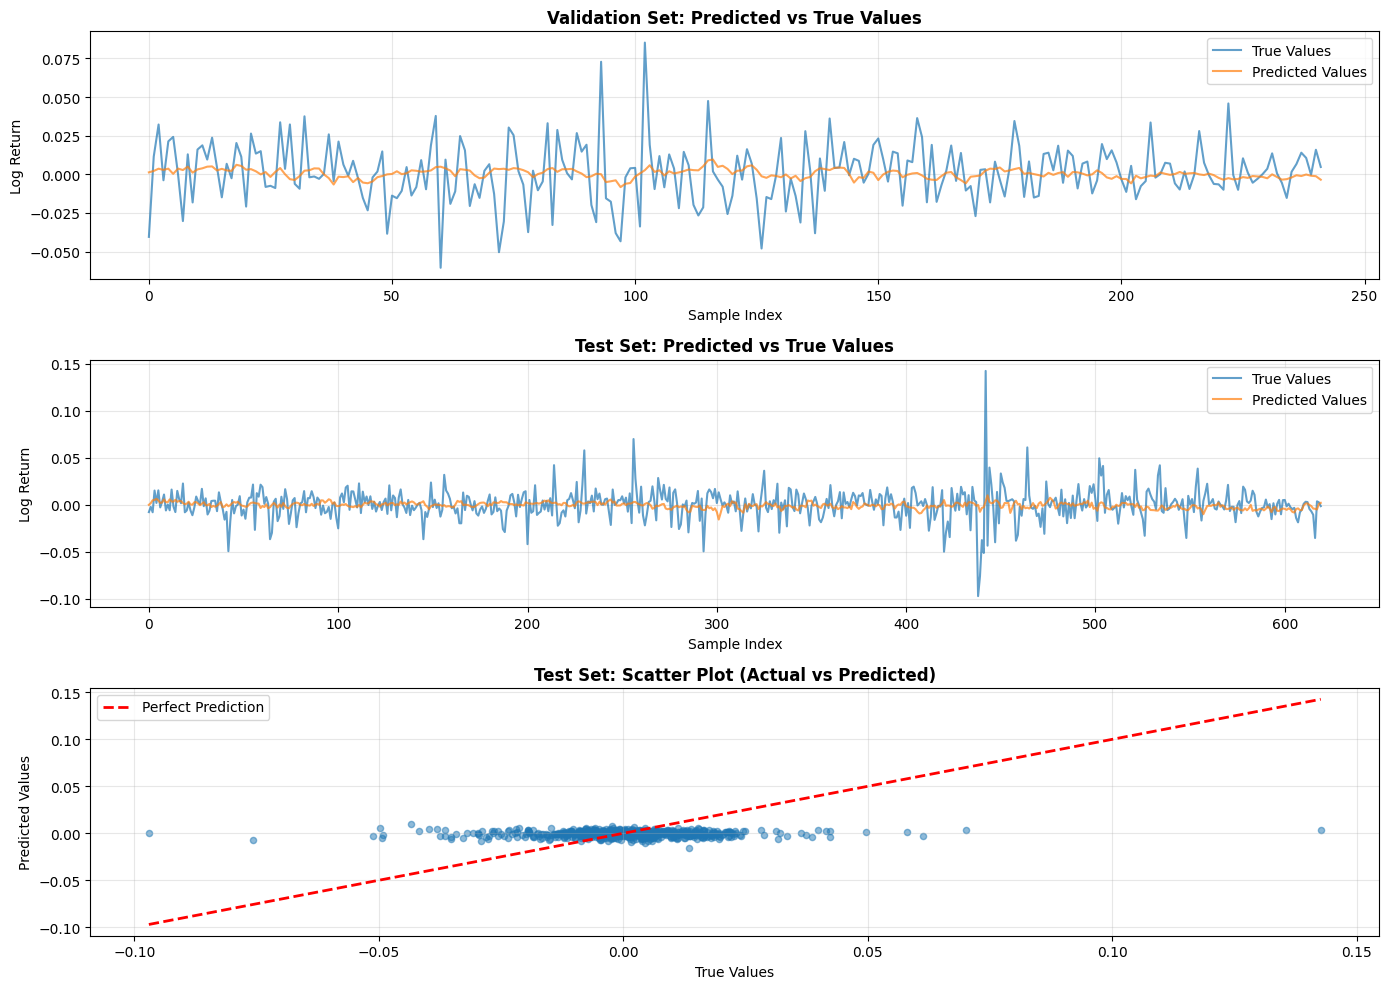


Validation Set Performance:
RMSE: 0.018994
R²: 0.024420

Test Set Performance:
RMSE: 0.016569
R²: -0.029529


In [18]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Validation set predictions vs actuals
axes[0].plot(yva_true, label='True Values', alpha=0.7, linewidth=1.5)
axes[0].plot(yva_pred, label='Predicted Values', alpha=0.7, linewidth=1.5)
axes[0].set_title('Validation Set: Predicted vs True Values', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Log Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Test set predictions vs actuals
axes[1].plot(y_true_te, label='True Values', alpha=0.7, linewidth=1.5)
axes[1].plot(y_pred_te, label='Predicted Values', alpha=0.7, linewidth=1.5)
axes[1].set_title('Test Set: Predicted vs True Values', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Log Return')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Scatter plot for test set (actual vs predicted)
axes[2].scatter(y_true_te, y_pred_te, alpha=0.5, s=20)
axes[2].plot([y_true_te.min(), y_true_te.max()], 
             [y_true_te.min(), y_true_te.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_title('Test Set: Scatter Plot (Actual vs Predicted)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('True Values')
axes[2].set_ylabel('Predicted Values')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nValidation Set Performance:")
print(f"RMSE: {rmse_np(yva_true, yva_pred):.6f}")
print(f"R²: {r2_np(yva_true, yva_pred):.6f}")

print("\nTest Set Performance:")
print(f"RMSE: {rmse_np(y_true_te, y_pred_te):.6f}")
print(f"R²: {r2_np(y_true_te, y_pred_te):.6f}")

In [19]:
# DIAG A: target distribution + baseline metrics (VAL + TEST)

def summarize_y(name, y):
    y = np.asarray(y).astype(float)
    print(f"\n{name}: n={len(y)} mean={y.mean():.6f} std={y.std():.6f} min={y.min():.6f} max={y.max():.6f}")

def metrics_block(name, y_true, y_pred):
    return {
        "set": name,
        "MAE": float(np.mean(np.abs(y_true - y_pred))),
        "RMSE": rmse_np(y_true, y_pred),
        "R2": r2_np(y_true, y_pred),
        "pred_std": float(np.std(y_pred)),
        "true_std": float(np.std(y_true)),
        "std_ratio": float(np.std(y_pred) / (np.std(y_true) + 1e-12)),
        "corr": float(np.corrcoef(y_true, y_pred)[0,1]) if np.std(y_pred) > 0 and np.std(y_true) > 0 else np.nan
    }

val_loader_dbg  = make_loader(Xva, yva, batch_size=256, shuffle=False)
test_loader_dbg = make_loader(Xte_seq, yte_seq, batch_size=256, shuffle=False)

yva_true, _ = predict_loader(final_model, val_loader_dbg)   # y_true from loader
yte_true, _ = predict_loader(final_model, test_loader_dbg)

summarize_y("VAL y", yva_true)
summarize_y("TEST y", yte_true)

# Baselines
val_mean = float(np.mean(yva_true))
test_mean = float(np.mean(yte_true))

yhat0_val  = np.zeros_like(yva_true)
yhatm_val  = np.full_like(yva_true, val_mean)

yhat0_test = np.zeros_like(yte_true)
yhatm_test = np.full_like(yte_true, test_mean)

print("\nBASELINES:")
print(metrics_block("VAL  predict_0", yva_true, yhat0_val))
print(metrics_block("VAL  predict_mean(val)", yva_true, yhatm_val))
print(metrics_block("TEST predict_0", yte_true, yhat0_test))
print(metrics_block("TEST predict_mean(test)", yte_true, yhatm_test))



VAL y: n=241 mean=0.018734 std=0.082006 min=-0.167054 max=0.211720

TEST y: n=616 mean=0.009798 std=0.065322 min=-0.247505 max=0.187641

BASELINES:
{'set': 'VAL  predict_0', 'MAE': 0.07054489850997925, 'RMSE': 0.0841185674071312, 'R2': -0.052187442779541016, 'pred_std': 0.0, 'true_std': 0.08200594037771225, 'std_ratio': 0.0, 'corr': nan}
{'set': 'VAL  predict_mean(val)', 'MAE': 0.0676782876253128, 'RMSE': 0.08200594037771225, 'R2': 0.0, 'pred_std': 0.0, 'true_std': 0.08200594037771225, 'std_ratio': 0.0, 'corr': nan}
{'set': 'TEST predict_0', 'MAE': 0.05364672467112541, 'RMSE': 0.06605246663093567, 'R2': -0.022497057914733887, 'pred_std': 0.0, 'true_std': 0.06532178074121475, 'std_ratio': 0.0, 'corr': nan}
{'set': 'TEST predict_mean(test)', 'MAE': 0.0523521825671196, 'RMSE': 0.06532178074121475, 'R2': 0.0, 'pred_std': 9.313225746154785e-10, 'true_std': 0.06532178074121475, 'std_ratio': 1.4257458446989388e-08, 'corr': nan}


/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [20]:
# DIAG B: model metrics on VAL + TEST
yva_true, yva_pred = predict_loader(final_model, val_loader_dbg)
yte_true, yte_pred = predict_loader(final_model, test_loader_dbg)

print("\nMODEL:")
print(metrics_block("VAL  model", yva_true, yva_pred))
print(metrics_block("TEST model", yte_true, yte_pred))



MODEL:
{'set': 'VAL  model', 'MAE': 0.06257263571023941, 'RMSE': 0.07705909013748169, 'R2': 0.11700719594955444, 'pred_std': 0.032512445002794266, 'true_std': 0.08200594037771225, 'std_ratio': 0.3964645104080058, 'corr': 0.35119836434674806}
{'set': 'TEST model', 'MAE': 0.06309177726507187, 'RMSE': 0.07652710378170013, 'R2': -0.37250685691833496, 'pred_std': 0.03242636099457741, 'true_std': 0.06532178074121475, 'std_ratio': 0.49640962977639086, 'corr': -0.0319846324521166}
